# Maze Solver
In this notebook, we write a maze solver by solving the Poisson equation with two Dirichlet boundary conditions imposed on the two faces that correspond to the start and end of the maze, respectively. 

The logic is pretty simple: once we have the solution, we just need to start off from one face and follow the gradient. Since the gradient in the deadends is almost close to 0, following the nonzero gradient should guide us toward the other side of the maze.

We implement two different approaches:

1. Direct numerical simulation
Here, we first convert the image into a Cubic network, trim the pores that correspond to the walls, and finally run a basic `OhmicConduction` (or `FickianDiffusion`) on the resulting trimmed network.

2. Network extraction
Here, we first use the SNOW algorithm to extract the equivalent network of the maze. Note that the nodes in the equivalent network will not exactly give us the corners of the maze, but at least it gives us a rough idea, enough for solving the maze! Then, like the first approach, we run a basic `OhmicConduction` on the extracted network. The advantage of this approach is that it's way faster due to much fewer unknowns.

Note: Inspired by this post by Jeremy Theler https://www.linkedin.com/posts/jeremytheler_how-to-solve-a-maze-without-ai-use-laplaces-activity-6831291311832760320-x9d5

In [13]:
# Install the required pmeal packages in the current Jupyter kernel
import sys
try:
    import openpnm as op
except:
    !{sys.executable} -m pip install openpnm
    import openpnm as op
try:
    import porespy as ps
except:
    !{sys.executable} -m pip install porespy
    import porespy as ps

In [2]:
import requests
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import porespy as ps
import openpnm as op
from openpnm.utils import tic, toc
from PIL import Image
from io import BytesIO
%config InlineBackend.figure_formats = ['svg']
ws = op.Workspace()
ws.settings["loglevel"] = 60

## Load maze samples

In [3]:
im_size = 'medium'

if im_size == 'small':
    url = 'https://imgur.com/ZLbV4eh.png'
elif im_size == 'medium':
    url = 'https://imgur.com/A3Jx8SJ.png'
else:
    url = 'https://imgur.com/FLJ21e5.png'

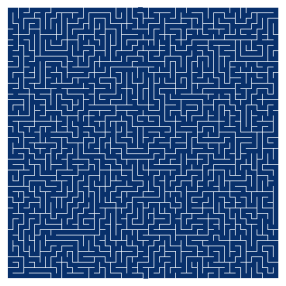

In [4]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
im = np.array(img.getdata()).reshape(img.size[0], img.size[1], 4)[:, :, 0]
im = im == 255

Nx, Ny, = im.shape

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(im, cmap='Blues', interpolation="none")
ax.axis("off");

## Approach A: Direct numerical simulation

## Thicken the walls to reduce number of unknowns

In [5]:
# Structuring element for thickening walls
strel = np.array([[1, 1, 1],
                  [1, 1, 1],
                  [1, 1, 1]])

# Save some computation by thickening the walls
def thicken_wall(im):
    return ~ndimage.morphology.binary_dilation(~im, structure=strel)

for _ in range(5):
    im = thicken_wall(im)

(-0.5, 801.5, 801.5, -0.5)

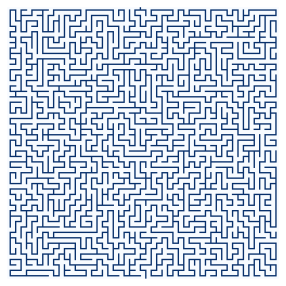

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(im, cmap='Blues', interpolation="none")
ax.axis("off")

## Convert the maze into a Cubic network

In [7]:
# Get top and bottom boundaries
BP_top = np.zeros_like(im)
BP_bot = np.zeros_like(im)
BP_top[0, :] = True
BP_bot[-1, :] = True
BP_top *= im
BP_bot *= im

# Make a cubis network with same dimensions as image and assign the props
net = op.network.Cubic(shape=[Nx, Ny, 1])
net['pore.index'] = np.arange(0, net.Np)
net['pore.BP_top'] = BP_top.flatten()
net['pore.BP_bot'] = BP_bot.flatten()

# Trim wall pores
op.topotools.trim(network=net, pores=~im.flatten())

## Solve the Poisson equation ($\nabla^2 \phi = 0$) on the maze

In [8]:
# Set up a dummy phase and apply uniform arbitrary conductance
phase = op.phases.GenericPhase(network=net)
phase['throat.electrical_conductance'] = 1.0

# Run algorithm
alg = op.algorithms.OhmicConduction(network=net, phase=phase)
alg.set_value_BC(pores=net.pores('BP_top'), values=0.0)
alg.set_value_BC(pores=net.pores('BP_bot'), values=1.0)
tic()
alg.run()
dt = toc(quiet=True);
print(f'Solve time: {dt:.3f} s')

Solve time: 0.567 s


## Follow the gradient!

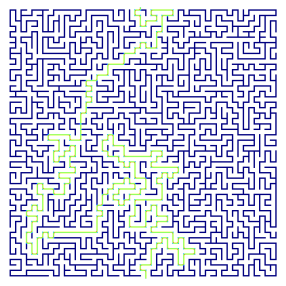

In [9]:
# Calculate flux in throats and show in pores
# Note: No need to calculate pore.rate as it auto interpolates from throat values
phase['throat.rate'] = alg.rate(throats=net.Ts, mode='single')
rate_im = np.ones([Nx, Ny]).flatten() * np.nan
rate_im[net['pore.index']] = phase['pore.rate']
rate_im = rate_im.reshape([Nx, Ny])

# Plot the maze solution
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(rate_im, cmap='jet', interpolation="none")
ax.axis("off");

## Approach B: Network extraction

## Network extraction using SNOW algorithm

In [10]:
# We need to pass image transpose since matrix xy coords is inverted
# i.e., row is x and col is y, whereas in Cartesian convention, it's the opposite.
out = ps.networks.snow2(im.T) 
proj = op.io.PoreSpy.import_data(out.network)
net = proj.network

Extracting pore and throat properties:   0%|          | 0/1488 [00:00<?, ?it/s]

## Solve the Poisson equation ($\nabla^2 \phi = 0$) on the extracted network

In [11]:
# Set up a dummy phase and apply uniform arbitrary conductance
phase = op.phases.GenericPhase(network=net)
phase['throat.electrical_conductance'] = 1.0

# Run algorithm
alg = op.algorithms.OhmicConduction(network=net, phase=phase)
alg.set_value_BC(pores=net.pores('ymin'), values=0.0)
alg.set_value_BC(pores=net.pores('ymax'), values=1.0)
tic()
alg.run()
dt = toc(quiet=True);
print(f'Solve time: {dt:.3f} s')

Solve time: 0.013 s


## Follow the gradient!

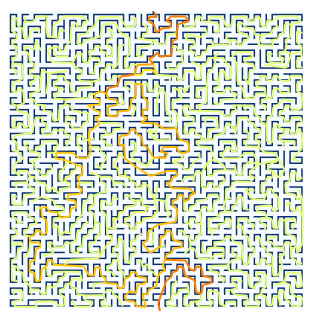

In [12]:
# Get throat rate values
phase['throat.rate'] = alg.rate(throats=net.Ts, mode='single')

# Plot the maze solution (i.e., throat rates!)
fig, ax = plt.subplots(figsize=(5, 5))
op.topotools.plot_connections(net, ax=ax,
                              color_by=phase["throat.rate"],
                              linewidth=2, cmap="Wistia")
ax.imshow(im, interpolation="none", cmap='Blues');
ax.axis("off");